# Dimentionality Reduction

## Instructions

- Download and open your copy of the notebook.
- Follow the instructions within the notebook to complete the analysis using the provided data files.
- Ensure that you upload the data files to your Google Drive before running the notebook, and adjust the file paths accordingly.
- Complete code when you see three dots (...)

## Remember:

We are using labeled data just to show the effect of the different algorithms. In reality, when working with unsupervised learning, you won't have the labels. This means that you'll need to rely on the intrinsic properties of your data to find meaningful patterns and structure. Dimensionality reduction helps to visualize and understand these patterns, but keep in mind:

1. **Interpretation Without Labels:** Without labels, you'll have to interpret the results based on the clustering, grouping, or distribution of the data points in the reduced dimensional space.
2. **Evaluation:** Since there are no labels, you might evaluate the effectiveness of the dimensionality reduction technique based on how well it separates distinct clusters or how it preserves the structure of the data.
3. **Exploration:** Use these techniques as exploratory tools to identify trends, outliers, and other important aspects of your data before moving on to more advanced analyses.

By experimenting with different methods, you'll gain a better understanding of which techniques work best for your specific dataset and objectives.



```
# This is formatted as code
```

Install packages and import them

In [3]:
# install packages
import umap

import ipywidgets as widgets
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

print('Successfully imported all packages')

Successfully imported all packages


## Helper functions

In [4]:
# Helper function for getting and plotting correlation heatmap
def get_correlation_heatmap(df, plot_flag=True):
  # Assuming your DataFrame is named df
  # 1. Calculate the correlation matrix
  corr_matrix = df.corr().abs()
  if plot_flag:
    # 2. Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # 3. Set up the matplotlib figure
    plt.figure(figsize=(8, 8))

    # 4. Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, linewidths=.5)

    # 5. Add title and labels
    plt.title('Correlation Matrix Heatmap', fontsize=16)
    plt.show()
  return corr_matrix

# Helper function for extracting pairs of variables with high correlation
def get_pairs_with_high_corr(corr_matrix, threshold=0.8):


  # Mask the upper triangle of the matrix and remove the diagonal
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

  # Apply the mask to the correlation matrix and get high correlation pairs
  high_corr = corr_matrix.where(mask).stack()
  high_corr = high_corr[high_corr > threshold]

  # Convert the result to a DataFrame
  high_corr_df = high_corr.reset_index()
  high_corr_df.columns = ['Variable 1', 'Variable 2', 'Correlation']
  high_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)
  return high_corr_df

# Helper function for plotting embedding
def plot_embedding(X_embedded, y, title):
    plt.figure(figsize=(10, 8))

    if y is not None:
        if isinstance(y[0], str):  # Check if labels are text
            unique_labels = np.unique(y)  # Get unique labels
            colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Generate colors

            for i, label in enumerate(unique_labels):
                plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1],
                            color=colors[i], label=label, edgecolor='k')

            plt.legend(title='Labels')
        else:
            scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis')
            plt.colorbar(scatter)
    # Add the title to the plot
    plt.title(title)

# Helper function for plotting PCA variance
def plot_pca_variance(n_components,cumulative_variance_ratio_all):

    cumulative_variance_ratio = cumulative_variance_ratio_all[:n_components]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance_ratio, marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA: Explained Variance Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:

# Step 2: Set the path to the CSV file
# Ensure you replace 'path_to_your_folder' and 'filename.csv' with their actual file path
csv_file_path = 'sound_acc.csv'

# data from:
# https://github.com/enriquegit/behavior-free-datasets

In [17]:
df_all = pd.read_csv(csv_file_path)
df=df_all.drop(['label'],axis=1)
y = df_all['label']

In [7]:
df_all.describe()

,v1_mfcc1,v1_mfcc2,v1_mfcc3,v1_mfcc4,v1_mfcc5,v1_mfcc6,v1_mfcc7,v1_mfcc8,v1_mfcc9,v1_mfcc10,...,v2_maxX,v2_maxY,v2_maxZ,v2_corXY,v2_corXZ,v2_corYZ,v2_meanMagnitude,v2_sdMagnitude,v2_auc,v2_meanDif
count,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,...,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1.386000e+03
mean,120.659467,-4.504259,-5.787432,-4.324000,-4.825497,-3.788440,-4.690573,-2.480306,-4.604397,-1.655253,...,0.536432,1.281976,0.800218,-0.094052,-0.265245,-0.125618,1.041049,0.161993,77.185500,-1.036610e-04
std,8.801973,4.519904,3.885086,2.461543,3.466517,2.253607,2.436451,2.924725,2.446138,2.084550,...,0.445107,0.808937,0.526431,0.419034,0.396965,0.430093,0.085482,0.169814,11.716791,4.528478e-03
min,102.782374,-17.199848,-20.902389,-16.869692,-17.385292,-14.303205,-14.523439,-14.227714,-16.232274,-10.628308,...,-0.592773,-0.051758,-0.569336,-0.958280,-0.971059,-0.993749,0.954546,0.001502,29.983772,-9.183864e-02
25%,115.487452,-8.144506,-7.953496,-5.867742,-6.549288,-5.193103,-5.815710,-3.857191,-5.852429,-2.931954,...,0.220947,0.848267,0.477600,-0.428407,-0.564988,-0.452535,1.000600,0.036520,72.156624,-9.389435e-04
50%,120.040872,-3.967480,-4.826121,-4.062119,-4.958848,-3.699664,-4.432076,-2.458651,-4.522926,-1.742899,...,0.477661,1.059937,0.827271,-0.098409,-0.314192,-0.166065,1.011917,0.107460,77.380178,-8.550000e-08
75%,125.858721,-1.304871,-3.088805,-2.749132,-3.143541,-2.264276,-3.238752,-0.971559,-3.285079,-0.404461,...,0.787781,1.537598,1.089050,0.197889,-0.003704,0.193795,1.054199,0.245783,83.045108,1.131441e-03
max,141.189588,8.979294,3.265064,2.918457,11.178750,4.725620,3.326617,9.548100,4.623490,9.988957,...,3.034668,7.999023,4.189453,0.952155,0.944848,0.960379,2.502673,1.871098,182.695101,1.669254e-02


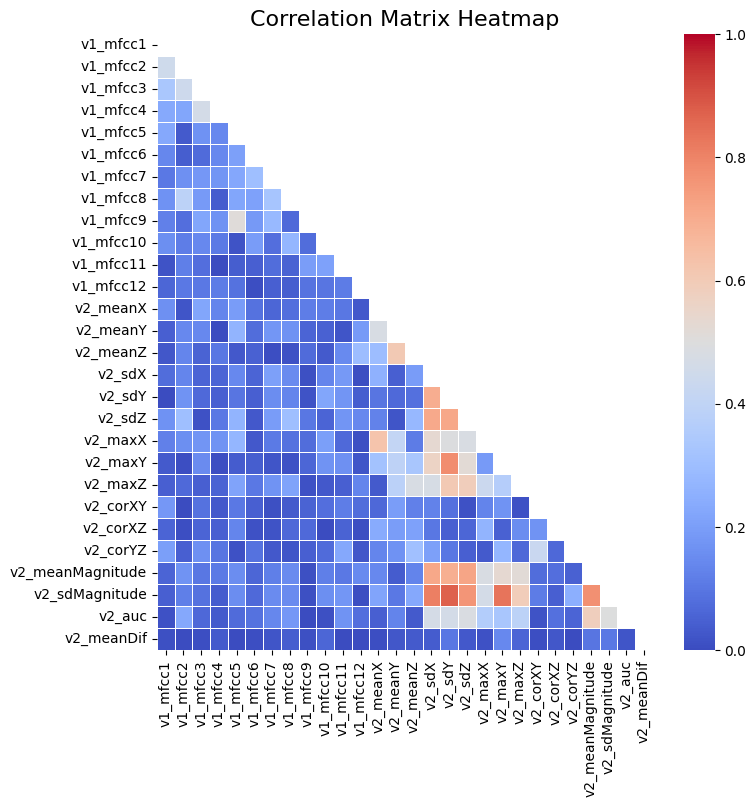

In [8]:
corr_matrix = get_correlation_heatmap(df, True)


In [9]:
high_corr_df = get_pairs_with_high_corr(corr_matrix, 0.5)
high_corr_df.head(10)

,Variable 1,Variable 2,Correlation
13,v2_sdY,v2_sdMagnitude,0.871444
19,v2_maxY,v2_sdMagnitude,0.834263
8,v2_sdX,v2_sdMagnitude,0.811003
10,v2_sdY,v2_maxY,0.778126
22,v2_meanMagnitude,v2_sdMagnitude,0.773317
17,v2_sdZ,v2_sdMagnitude,0.758073
16,v2_sdZ,v2_meanMagnitude,0.721647
9,v2_sdY,v2_sdZ,0.714417
7,v2_sdX,v2_meanMagnitude,0.713873
4,v2_sdX,v2_sdZ,0.708053


In [10]:
# Preprocess the data
X = df.values
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode layers
y_txt = df_all['label']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_txt)

## Insights on Correlation

When analyzing data, high correlations between variables can suggest redundancy, meaning that some variables might be telling you the same thing. In the table above, for example, many features derived from accelerometer data (v2_sdY, v2_sdMagnitude, v2_maxY, etc.) show high correlations with each other. This redundancy might indicate that you don't need all these variables to describe the data effectively.

### Questions for Thought:

1. If several variables are highly correlated, how would you decide which one(s) to keep?
2. Could removing redundant variables affect the performance of your model? How?
3. How might these correlations influence dimensionality reduction techniques like PCA or UMAP?
4. What additional insights could be gained by combining or transforming these variables?

By thinking through these questions, you can better understand the implications of correlation in your data and make more informed decisions during analysis.

# 1. Principal Component Analysis (PCA)

PCA is a linear dimensionality reduction technique that identifies the axes of maximum variance in high-dimensional data and projects the data onto a lower-dimensional subspace along those axes.
Key characteristics of PCA:
- Linear: It assumes linear relationships in the data.
- Unsupervised: It doesn't use target variables.
- Preserves global structure: It maintains the global structure of the data.
- Interpretable: Principal components can often be interpreted in terms of original features.


Variance explained by the first two principal components: 0.33


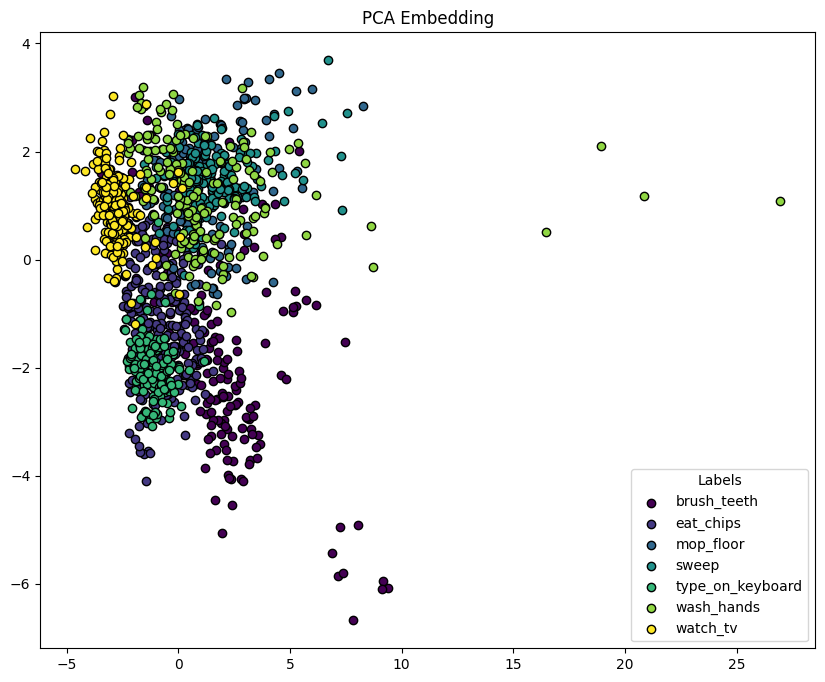

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plot_embedding(X_pca[:,:2], y_txt, "PCA Embedding")

print(f"\nVariance explained by the first two principal components: {pca.explained_variance_ratio_.sum():.2f}")

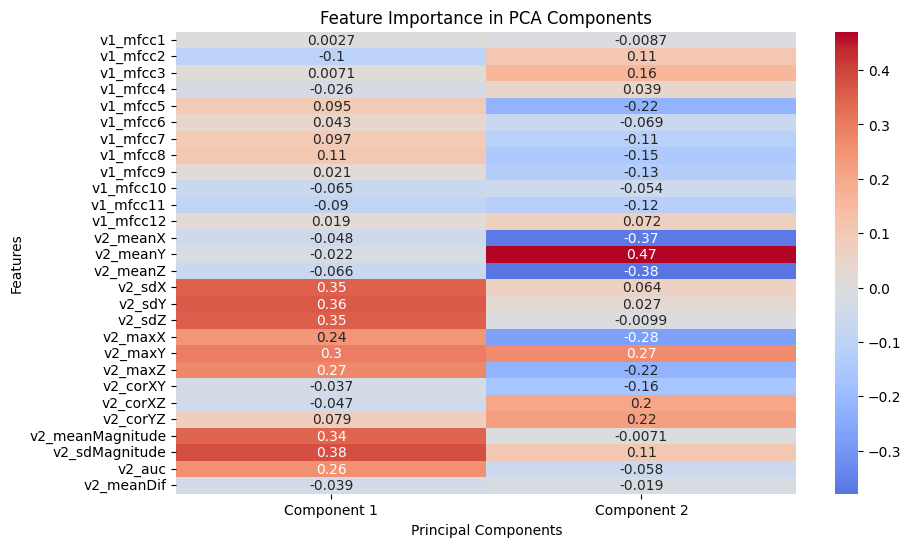

In [12]:
# Extract the components (importance of each feature for each component)
components = pca.components_


feature_names = df.columns
# Create a DataFrame for easier plotting
# Each row is a feature, and each column is a principal component
df_pca = pd.DataFrame(components[:2],  # Only the first 2 components
                      columns=feature_names)  # Feature names as columns

# Transpose to have features as rows and components as columns
df_pca = df_pca.T
df_pca.columns = ['Component 1', 'Component 2']

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_pca, annot=True, cmap="coolwarm", center=0)
plt.title('Feature Importance in PCA Components')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()



In [13]:
# Show hint

In [14]:
# @title
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

## Principal Component Analysis (PCA) and the Optimal Number of Components

Principal Component Analysis (PCA) is a dimensionality reduction technique used to simplify complex datasets by transforming them into a lower-dimensional space while retaining as much variability as possible. The goal of PCA is to identify the principal components, or directions of maximum variance, in the data.

As we increase the number of components in PCA, we capture more of the variance present in the original dataset. Each additional component accounts for some of the remaining variance, allowing us to explain a greater portion of the dataset's variability. This process is visualized by plotting the cumulative explained variance ratio against the number of components.

However, simply increasing the number of components indefinitely is not always desirable. While more components explain more variance, they may also introduce noise or lead to overfitting. This results in diminishing returns where additional components contribute less meaningful information.

## Finding the Sweet Spot:

To identify the optimal number of components, we seek a balance where adding more components yields a substantial increase in explained variance without excessive complexity. Typically, we look for the **"elbow point"** in the cumulative explained variance plot—where the curve starts to flatten out. This point represents the sweet spot where adding further components yields marginal gains in explained variance, providing a good trade-off between simplicity and explanation power.

In practical terms, selecting a number of components that captures a high percentage (e.g., 95%) of the variance is often a common approach. This ensures that we retain most of the important information while reducing dimensionality to a manageable level.

By carefully choosing the number of components, we can effectively reduce the complexity of our data while preserving the critical patterns and relationships necessary for analysis.

## Task
Explore the interactive slider to adjust the number of PCA components and observe how the explained variance changes. As you increase the number of components, you will notice that the cumulative explained variance ratio increases, capturing more of the variability in the data.

Objective:

- Use the slider to experiment with different numbers of components.
- Observe how the cumulative explained variance ratio evolves as you add more components.
- Identify the point where adding more components yields only marginal improvements in explained variance. This point represents a balance between retaining significant variance and avoiding unnecessary complexity.

Questions to Consider:

- How many components are needed to explain a high percentage of the variance (e.g., 95%)?
- At what point does the increase in explained variance become minimal, indicating the sweet spot for the number of components?

This exercise will help you understand the trade-off between dimensionality and the amount of variance captured, guiding you in selecting an optimal number of components for your PCA analysis.

In [15]:
# @title
# Run this first

pca_all = PCA(n_components=X_scaled.shape[1]).fit(X_scaled)
cumulative_variance_ratio_all = np.cumsum(pca_all.explained_variance_ratio_)
n_components_slider = widgets.IntSlider(
    value=2,
    min=1,
    max=X_scaled.shape[1],
    step=1,
    description='Components:',
    continuous_update=False,
    layout=widgets.Layout(width='50%')  # Adjust width here
)

# Display the interactive plot with the slider
widgets.interact(plot_pca_variance, n_components=n_components_slider, cumulative_variance_ratio_all=widgets.fixed(cumulative_variance_ratio_all))

interactive(children=(IntSlider(value=2, continuous_update=False, description='Components:', layout=Layout(wid…

<function __main__.plot_pca_variance(n_components, cumulative_variance_ratio_all)>

# 2. t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is a nonlinear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.
Key characteristics of t-SNE:
- Nonlinear: Can capture complex, nonlinear relationships in the data.
- Stochastic: Results can vary between runs due to its probabilistic nature.
- Preserves local structure: Focuses on preserving the local structure of the data.
- Not interpretable: The dimensions in t-SNE space don't have clear meanings in terms of original features.


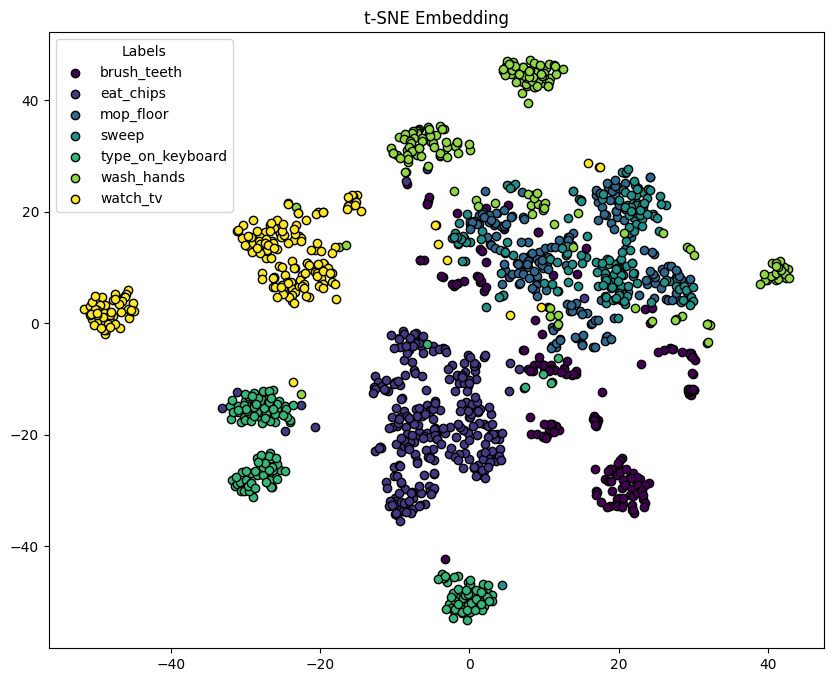

In [21]:
tsne =  TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled) # Continue

plot_embedding(X_tsne, y_txt, "t-SNE Embedding")


In [ ]:
# Hint

In [ ]:
# @title
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X_scaled)

## t-SNE Parameters:
1. perplexity:
   - Effect: Balance between preserving local and global structure. Affects the size of the local neighborhood.
   - How to choose:
     - Typically, between 5 and 50.
     - For smaller datasets, use smaller values (5-10).
     - For larger datasets, use larger values (30-50).
     - Experiment with different values and compare results.

2. n_iter:
   - Effect: Number of iterations for optimization.
   - How to choose:
     - Default is 1000, which is often sufficient.
     - Increase if the plot looks 'unfinished' or if the KL divergence is still decreasing.

3. learning_rate:
   - Effect: Step size for gradient descent.
   - How to choose:
     - Default is 200, which works well in most cases.
     - If the resulting plot looks like a 'ball', decrease it.
     - If the resulting plot looks like sparse clouds, increase it.

4. early_exaggeration:
   - Effect: How tight natural clusters are in the early stages of optimization.
   - How to choose:
     - Default is 12.0, which works well in most cases.
     - Increase for datasets with dense clusters.




Example of choosing perplexity:


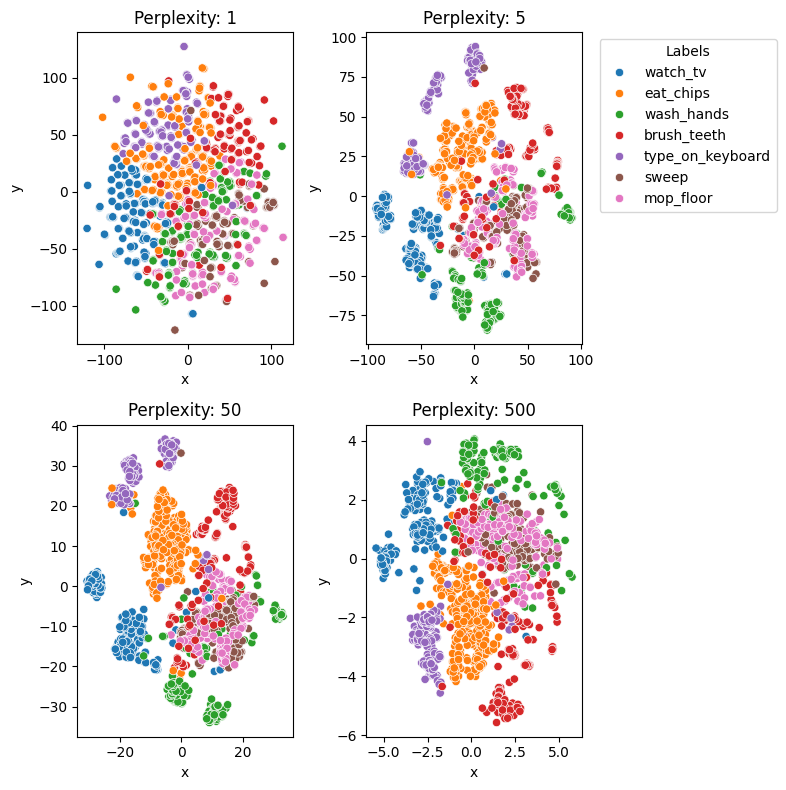

In [ ]:
print("\nExample of choosing perplexity:")
perplexities = [1, 5, 50, 500]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, perplexity in enumerate(perplexities):
    ax = axes[i//2, i%2]
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_scaled)
    temp_df = pd.DataFrame(X_tsne, columns=['x', 'y'])
    temp_df['label'] = y_txt
    sns.scatterplot(data=temp_df, x='x', y='y', hue='label', ax=ax)
    ax.set_title(f'Perplexity: {perplexity}')
    if i == 1:
       ax.legend(title='Labels',bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
      ax.legend_.remove()
plt.tight_layout()
plt.show()

## Exploring Perplexity in t-SNE

### Explanation:

In t-SNE (t-Distributed Stochastic Neighbor Embedding), the perplexity parameter plays a crucial role in determining how the algorithm balances the attention between local and global data structures.

- Perplexity is a measure that helps to set the number of nearest neighbors that influence the representation of each data point. It can be thought of as a trade-off between focusing on local versus global aspects of the data.
- Low Perplexity: When the perplexity is low, t-SNE focuses more on the local structure, emphasizing the relationships between very close neighbors. This can lead to more tightly clustered points but might overlook broader data patterns.
- High Perplexity: When the perplexity is high, t-SNE incorporates more global structure, considering a larger number of neighbors. This can reveal broader patterns but might make clusters less distinct.

In the provided example, different perplexity values (1, 5, 50, 500) are used to visualize how the representation of the data changes:

1. Perplexity 1: Emphasizes local relationships. Clusters may appear very tight but might not capture the overall data structure.
2. Perplexity 5: Provides a balance between local and global structure, often resulting in a clearer and more interpretable clustering.
3. Perplexity 50: Includes a larger number of neighbors, which can help reveal more global data patterns but may make individual clusters less distinct.
4. Perplexity 500: Focuses more on the global structure. The clusters might be less well-defined, but the overall distribution might become clearer.

### Questions to Consider:

1. How does the choice of perplexity affect the clustering of data points?
- Observe how clusters change in size and shape as you vary perplexity. Are the clusters more distinct with low perplexity, or do they reveal different patterns with higher perplexity?

2. What trade-offs can you identify when selecting a perplexity value?
- Consider the balance between local and global structure. Does a lower perplexity give you better-defined clusters, or does a higher perplexity provide a more comprehensive view of the data?

3. How might the choice of perplexity impact your interpretation of the data?
- Reflect on how different perplexity values influence the visual representation of the data and what insights you can gain from each.

4. What perplexity value gives you the most meaningful insight into your data?
- Based on your observations, determine which perplexity value offers the most useful visualization for understanding the structure and patterns within your dataset.

By exploring these different perplexity settings, you can gain a deeper understanding of how t-SNE captures and represents the structure of high-dimensional data. This exercise helps you appreciate the impact of parameter choices on data visualization and interpretation.

# 3. Uniform Manifold Approximation and Projection (UMAP)

UMAP is a dimension reduction technique that can be used for visualization similarly to t-SNE, but also for general non-linear dimension reduction.")
Key characteristics of UMAP:
- Nonlinear: Can capture complex, nonlinear relationships in the data.
- Deterministic: Given the same hyperparameters and initialization, it produces the same result.
- Preserves both local and global structure: Attempts to balance local and global structure preservation.
- Faster than t-SNE: Especially for larger datasets.






## UMAP Parameters:
1. n_neighbors:
   - Effect: Controls how UMAP balances local versus global structure in the data.
   - How to choose:
     - Lower values (e.g., 5-15) preserve local structure but may fragment data.
     - Higher values (e.g., 30-100) preserve more global structure.
     - Start with the square root of the number of samples and adjust based on results.

2. min_dist:
   - Effect: Controls how tightly UMAP is allowed to pack points together.
   - How to choose:
     - Lower values (e.g., 0.0-0.2) result in tighter, more clustered embeddings.
     - Higher values (e.g., 0.5-0.8) result in more evenly dispersed embeddings.
     - Default is 0.1, which often works well.

3. n_components:
   - Effect: The dimension of the space to embed into.
   - How to choose:
     - For visualization, use 2 or 3.
     - For dimensionality reduction, you might use more, guided by downstream task requirements.


## Explore UMAP Parameter Effects

In this section, you'll be exploring how different parameters in UMAP affect the resulting embeddings. UMAP (Uniform Manifold Approximation and Projection) is a powerful technique for dimensionality reduction that can be used for visualization and general non-linear dimension reduction. By adjusting UMAP parameters, you can observe how the embeddings change and understand the impact of each parameter.
### Task Instructions:

1. Adjust UMAP Parameters: Modify the UMAP parameters n_neighbors, min_dist, and n_components in the provided code. Observe how these changes affect the resulting 2D embedding of the dataset.
2. Visualize the Changes: Use the plot_embedding function to visualize the effects of different parameter settings. You should compare different embeddings to understand the impact of parameter adjustments.

### Questions to Consider:

1. Effect of n_neighbors:
  - How does changing n_neighbors (e.g., 5 vs. 50) affect the clustering of data points in the embedding?
  - Do you notice any changes in the balance between local and global structure preservation?

2. Effect of min_dist:
  - What impact does adjusting min_dist (e.g., 0.1 vs. 0.5) have on the tightness and dispersion of clusters?
  - How does it affect the visual separation of clusters or points?

3. Effect of n_components:
  - How does changing n_components (e.g., 2 vs. 3) influence the visualization of the data?
  - Are there any notable differences when using more than 2 components for visualization?

4. Overall Observations:
  - How do the changes in parameters influence the interpretability of the embeddings?
  - What combinations of parameters provide the most meaningful or insightful visualizations?

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


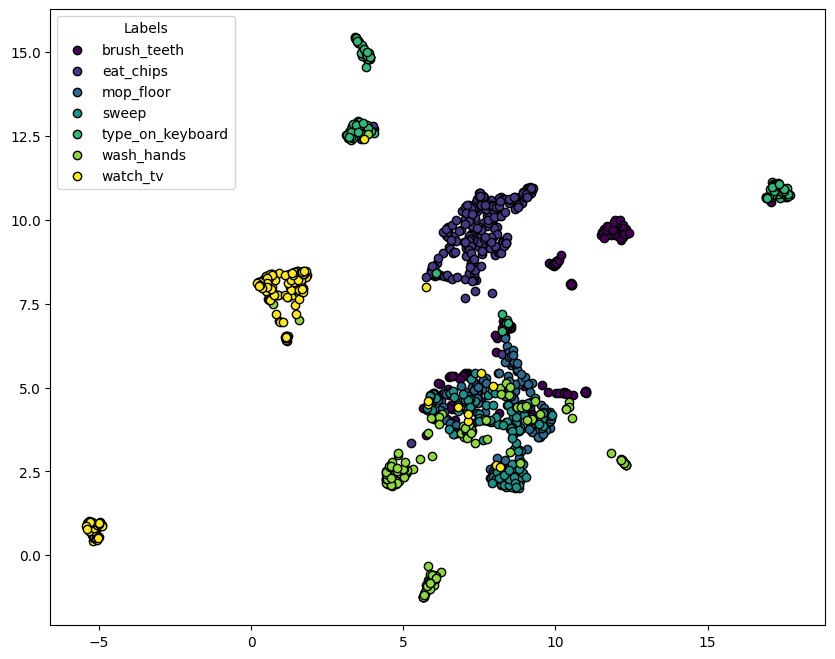

In [ ]:
reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=20, min_dist=0.1)
X_umap = reducer.fit_transform(X_scaled)

plot_embedding(X_umap, y_txt, "UMAP Embedding")


In [ ]:
# Hint

In [ ]:
# @title
# reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=20, min_dist=0.1)
# X_umap = reducer.fit_transform(X_scaled)


### Insights:

- ***n_neighbors***: A smaller number of neighbors emphasizes local structure, which can make clusters more distinct but may lead to fragmented data. A larger number provides a more global view, potentially blending clusters but offering a broader perspective on data relationships.

- ***min_dist***: Lower values lead to more tightly packed clusters, which can reveal more detailed local structure. Higher values spread out the points more, providing a clearer overall structure but possibly losing some fine-grained details.

- ***n_components***: While 2 components are typically used for visualization, increasing the number of components can be useful for preserving more structure in higher dimensions, though this may make visualization more complex.

# 4. Autoencoders

Autoencoders are a type of neural network that learn to compress data into a lower-dimensional representation (encoding) and then reconstruct the original data from this compressed form (decoding). The goal is to capture the essential features of the data in a more compact form, which can be useful for various tasks like dimensionality reduction, anomaly detection, and data denoising.

## Structure:
1. Encoder: Compresses the input data into a smaller, latent space representation.
2. Latent Space: The reduced-dimensional representation where important features are captured.
3. Decoder: Reconstructs the input data from the latent space representation.

## Training Process:
1. The network is trained to minimize the difference between the input data and its reconstruction.
2. This process encourages the model to focus on the most important patterns in the data, discarding noise and less relevant information.

## Applications:
1. Dimensionality Reduction: Autoencoders can reduce the number of features while preserving important information, similar to PCA but with the ability to capture non-linear relationships.
2. Anomaly Detection: Since autoencoders learn to reconstruct normal data well, they can identify anomalies as data points with high reconstruction errors.
3. Data Denoising: By training on noisy data and reconstructing the clean version, autoencoders can effectively remove noise from data.

## Advantages:
1. Capable of capturing complex, non-linear dependencies.
1. Flexible architecture that can be adapted to various types of data (e.g., images, time-series).

## Challenges:
1. Requires a large amount of data for training.
2. Tuning the network architecture (e.g., number of layers, neurons) and regularization is critical to avoid overfitting.




In [22]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


# Convert X_scale to a PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

# Split the data into training and validation sets
train_size = int(0.8 * len(X_tensor))
val_size = len(X_tensor) - train_size
train_dataset, val_dataset = random_split(X_tensor, [train_size, val_size])

# Create DataLoaders for batch processing with batch size
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using device: cpu


In [23]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 2)  # Bottleneck with dimension 2 for visualization
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 28),
            # nn.Sigmoid()  # Use Sigmoid to map the output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
# Initialize the model, loss function, and optimizer, and move the model to the device
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Variables to track the best model and early stopping
best_loss = float('inf')
best_model_path = 'best_autoencoder.pth'
epochs_no_improve = 0
early_stop_patience = 5  # Stop if no improvement for 300 epochs

# Set parameters
num_epochs = 2000
k = 100  # Display progress every k epochs

# Train the autoencoder
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        inputs = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    # Reduce learning rate by half every 200 epochs
    if (epoch + 1) % 200 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5
            new_lr = param_group['lr']
        print(f'Learning rate reduced by half at epoch {epoch + 1}: {new_lr}')

    # Check validation and print progress every k epochs
    if (epoch + 1) % k == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs = data
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        # Check if the current model is the best
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f'Best model saved with loss {best_loss:.4f}')
            epochs_no_improve = 0  # Reset counter if improvement is found
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs.')

        # Early stopping
        if epochs_no_improve >= early_stop_patience:
            print(f'Early stopping triggered. No improvement for {early_stop_patience} epochs.')
            break

# Load the best model for inference
model.load_state_dict(torch.load(best_model_path))

Epoch [100/2000], Validation Loss: 0.4249
Best model saved with loss 0.4249
Learning rate reduced by half at epoch 200: 0.0005
Epoch [200/2000], Validation Loss: 0.4184
Best model saved with loss 0.4184
Epoch [300/2000], Validation Loss: 0.4262
No improvement for 1 epochs.
Learning rate reduced by half at epoch 400: 0.00025
Epoch [400/2000], Validation Loss: 0.4731
No improvement for 2 epochs.
Epoch [500/2000], Validation Loss: 0.4634
No improvement for 3 epochs.
Learning rate reduced by half at epoch 600: 0.000125
Epoch [600/2000], Validation Loss: 0.4784
No improvement for 4 epochs.
Epoch [700/2000], Validation Loss: 0.4896
No improvement for 5 epochs.
Early stopping triggered. No improvement for 5 epochs.


C:\Users\David\AppData\Local\Temp\ipykernel_1628\1569567025.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [25]:
# Evaluate the autoencoder
model.eval()
with torch.no_grad():
  encoded_data = model.encoder(X_tensor).cpu().numpy()
    # reconstructed_data = model.decoder(torch.tensor(encoded_data, dtype=torch.float32)).cpu().numpy()

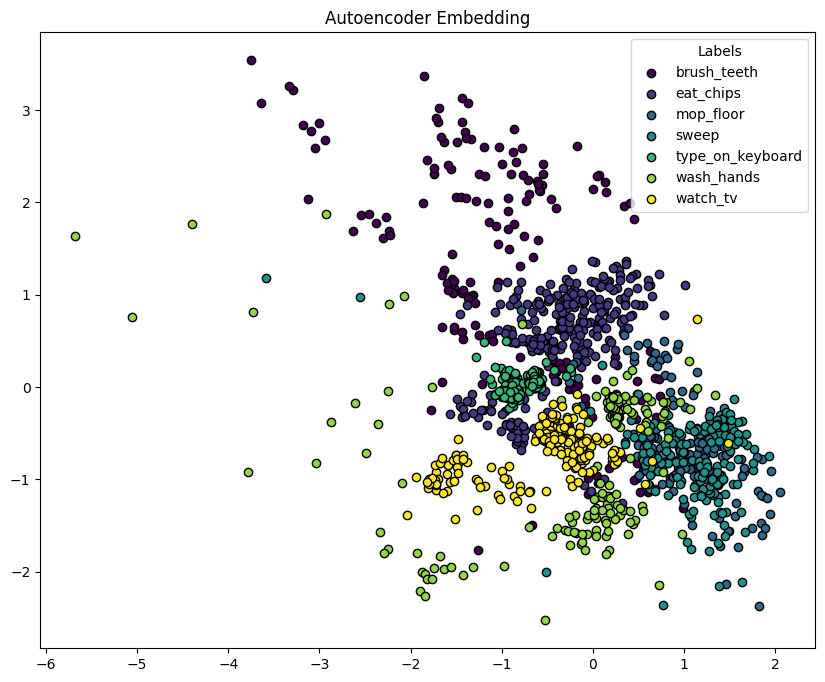

In [26]:
plot_embedding(encoded_data, y_txt, "Autoencoder Embedding")

## 4.2 Variational autoencoder (VAEs):

Variational Autoencoders (VAEs) are a type of generative model that extend the basic autoencoder framework to learn a probabilistic mapping from the data to a latent space, allowing for more meaningful and controlled data generation.

## Probabilistic Latent Space:
1. Unlike standard autoencoders, VAEs learn a distribution over the latent space.
2. Instead of mapping inputs to a single point in the latent space, VAEs encode inputs as distributions (typically Gaussian) defined by mean and variance parameters.

## Sampling:
1. During training, the model samples from these distributions to generate latent representations, ensuring that the latent space is continuous and allows for smooth interpolation between data points.
2. This makes it possible to generate new data by sampling from the latent space.

## Loss Function:
1. The loss in a VAE is composed of two parts:
2. Reconstruction Loss: Similar to traditional autoencoders, it measures how well the decoder reconstructs the input.
3. KL Divergence: This term ensures that the learned latent space distribution is close to a standard normal distribution, encouraging the encoded representations to be continuous and structured.

## Applications:
1. Generative Modeling: VAEs can generate new, realistic data samples by sampling from the latent space.
2. Data Imputation: VAEs can be used to fill in missing values in data by sampling from the learned distribution.
3. Anomaly Detection: Similar to standard autoencoders, VAEs can be used to identify anomalies by measuring reconstruction errors.

## Advantages:
1. The ability to generate new data that is similar to the training data.
2. Provides a smooth latent space that can be used for tasks like interpolation and data augmentation.

## Challenges:
1. Training VAEs can be more complex and computationally intensive than standard autoencoders.
2. The trade-off between reconstruction accuracy and latent space regularization (controlled by the KL Divergence term) requires careful tuning.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Variational Autoencoder model
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.BatchNorm1d(8)
        )
        self.fc_mu = nn.Linear(8, 2)  # Mean vector
        self.fc_logvar = nn.Linear(8, 2)  # Log-variance vector

        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 28)  # Linear output since data is scaled
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def transform(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar


In [ ]:
# KL Divergence loss
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def vae_loss(recon_x, x, mu, logvar, gamma=0.7):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # variance_penalty = torch.sum(logvar.pow(2))  # L2 penalty on log variance

    return gamma*recon_loss + (1-gamma)*kl_loss

In [ ]:
# Initialize the VAE model, loss function, and optimizer, and move the model to the device
model = VariationalAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Variables to track the best model and early stopping
best_loss = float('inf')
best_model_path = 'best_vae.pth'
epochs_no_improve = 0
early_stop_patience = 10  # Stop if no improvement for n epochs

# Set parameters
num_epochs = 5000
k = 100  # Display progress every k epochs

# KL Divergence loss
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Train the VAE
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        inputs = data.to(device)
        optimizer.zero_grad()
        outputs, mu, logvar = model(inputs)
        recon_loss = criterion(outputs, inputs)
        kl_loss = kl_divergence(mu, logvar)
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

    # Reduce learning rate by half every j epochs if there is no improvment
    if (epoch + 1) % 300 == 0 and epochs_no_improve>0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5
        print(f'Learning rate reduced by half at epoch {epoch + 1}')

    # Check validation and print progress every k epochs
    if (epoch + 1) % k == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs = data.to(device)
                outputs, mu, logvar = model(inputs)
                recon_loss = criterion(outputs, inputs)
                kl_loss = kl_divergence(mu, logvar)
                val_loss += (recon_loss + kl_loss).item()

        val_loss /= len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        # Check if the current model is the best
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f'Best model saved with loss {best_loss:.4f}')
            epochs_no_improve = 0  # Reset counter if improvement is found
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs.')

        # Early stopping
        if epochs_no_improve >= early_stop_patience:
            print(f'Early stopping triggered. No improvement for {early_stop_patience} epochs.')
            break

# Load the best model for inference
model.load_state_dict(torch.load(best_model_path))

Epoch [100/5000], Validation Loss: 1.3752
Best model saved with loss 1.3752
Epoch [200/5000], Validation Loss: 1.0714
Best model saved with loss 1.0714
Epoch [300/5000], Validation Loss: 0.9918
Best model saved with loss 0.9918
Epoch [400/5000], Validation Loss: 0.9622
Best model saved with loss 0.9622
Epoch [500/5000], Validation Loss: 0.9375
Best model saved with loss 0.9375
Epoch [600/5000], Validation Loss: 0.9262
Best model saved with loss 0.9262
Epoch [700/5000], Validation Loss: 0.9199
Best model saved with loss 0.9199
Epoch [800/5000], Validation Loss: 0.9098
Best model saved with loss 0.9098
Epoch [900/5000], Validation Loss: 0.8963
Best model saved with loss 0.8963
Epoch [1000/5000], Validation Loss: 0.9099
No improvement for 1 epochs.
Epoch [1100/5000], Validation Loss: 0.9051
No improvement for 2 epochs.
Learning rate reduced by half at epoch 1200
Epoch [1200/5000], Validation Loss: 0.9092
No improvement for 3 epochs.
Epoch [1300/5000], Validation Loss: 0.9038
No improvemen

<All keys matched successfully>

In [ ]:
# Evaluate the VAE
model.eval()
with torch.no_grad():
    # Pass the input data through the encoder
    encoded_data ,mu, logvar  = model.transform(X_tensor.to(device))

    # Move encoded data to CPU and convert to numpy array
    encoded_data = encoded_data.cpu().numpy()

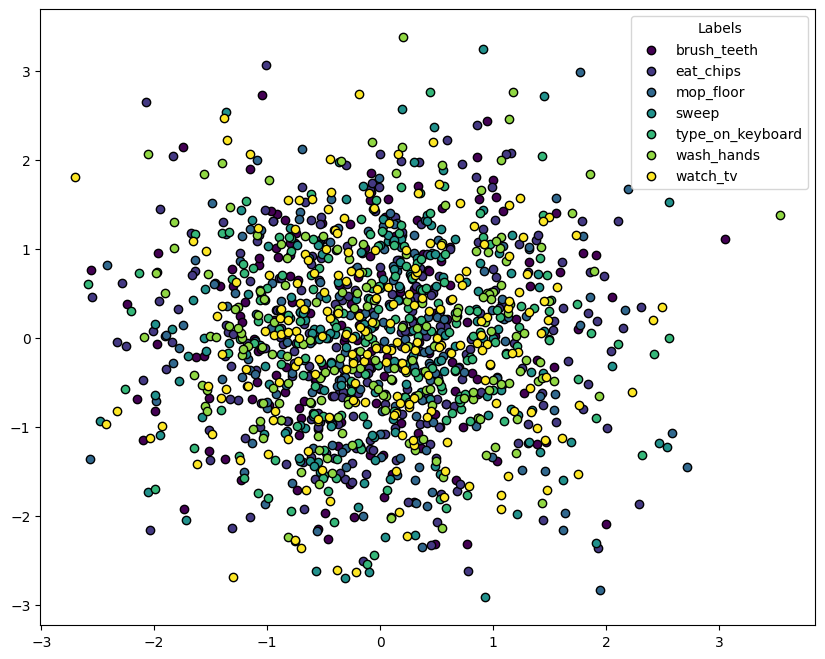

In [ ]:
plot_embedding(encoded_data, y_txt, "Variational Autoencoder Embedding")

# Supplemental: Exploring Additional Dimensionality Reduction Methods

Dimensionality reduction isn't just about PCA, t-SNE, or UMAP—there are many more techniques out there, each suited for different scenarios. Below are a few more methods you can try. When to use them? Well, that depends on your specific needs. To dive deeper into any of these methods, be sure to check out their documentation.

1. Manifold Learning (t-SNE, UMAP)
2. Principal Component Analysis (PCA)
3. Independent Component Analysis (ICA)
4. Sequential Non-negative Matrix Factorization (NMF)
4. Linear Discriminant Analysis (LDA)
5. Generalized Discriminant Analysis (GDA)
6. Missing Values Ratio (MVR): Threshold Setting
7. Low Variance Filter
8. High Correlation Filter
9. Forward Feature Construction
10. Backward Feature Elimination
11. Variational Autoencoders (VAE)


https://encord.com/blog/dimentionality-reduction-techniques-machine-learning/

In [ ]:
from sklearn.decomposition import FastICA
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding as LLE
from sklearn.decomposition import NMF, FastICA

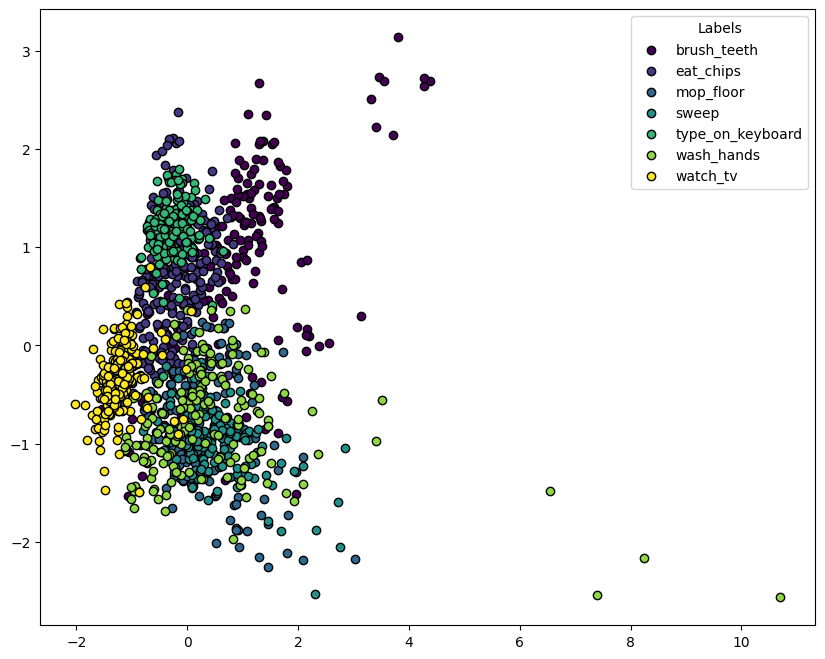

In [ ]:
# ICA
ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_scaled)
plot_embedding(X_ica, y_txt, "ICA")

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


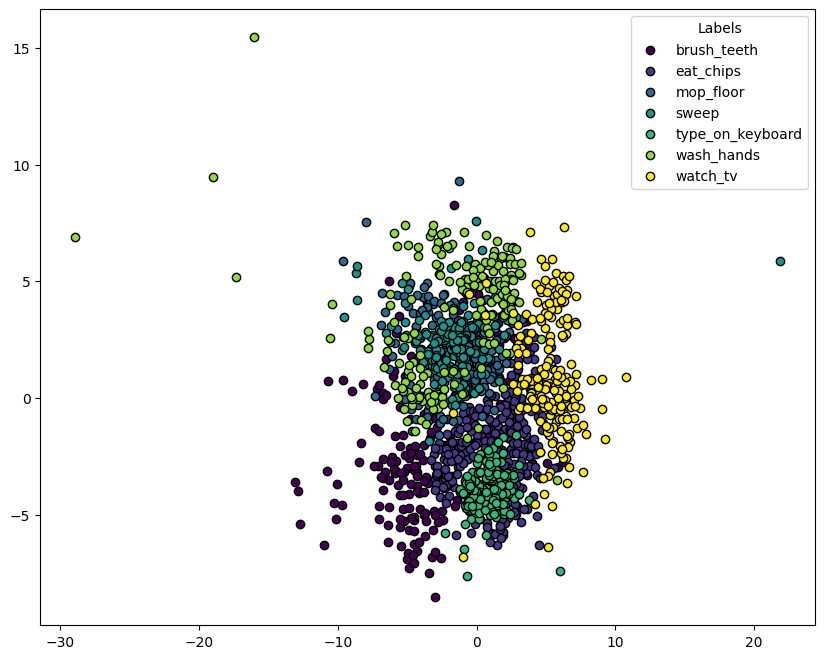

In [ ]:
# MDS
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_scaled)
plot_embedding(X_mds, y_txt, "MDS")

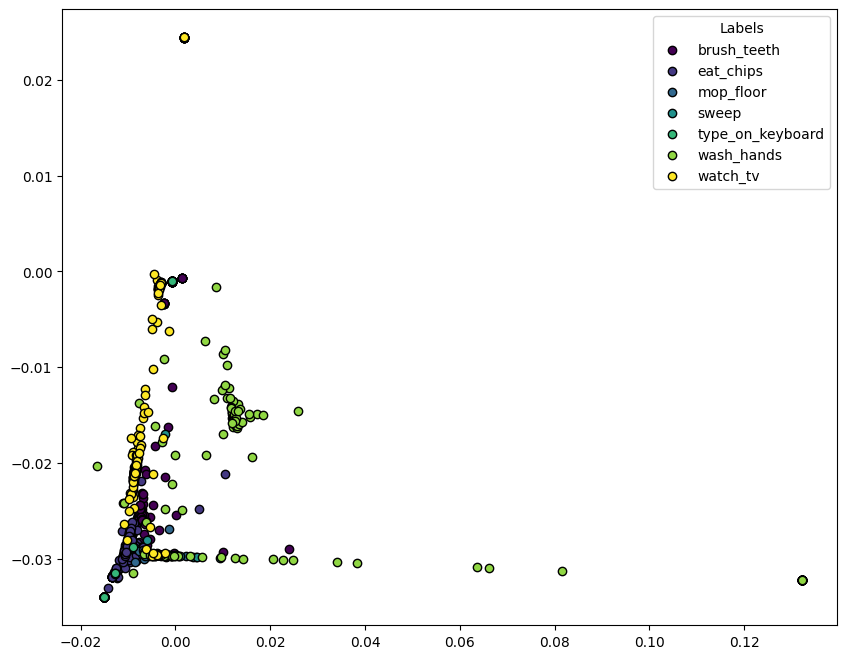

In [ ]:
# LLE
lle = LLE(n_components=2)
X_lle = lle.fit_transform(X_scaled)
plot_embedding(X_lle, y_txt, "LLE")

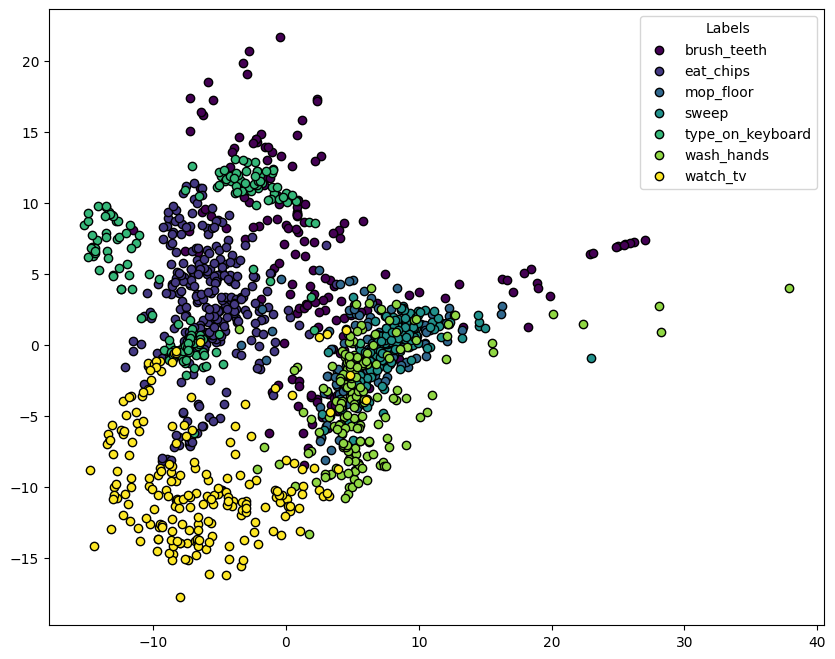

In [ ]:
# Isomap
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)
plot_embedding(X_isomap, y_txt, "Isomap")